# Data Preparation

## Load data from excel in pandas DataFrame

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import pymc as pm
import arviz as az

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator, MultipleLocator,AutoMinorLocator
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
sns.set()

import warnings
warnings.filterwarnings('ignore')

data_file_path = 'data/study1_data.xlsx'
df = pd.read_excel(data_file_path)

# df.columns
## columns 0-5: automatically created by MS Forms
## column "ID": this is an automatically generated ID. It starts at 14. The previous IDs were used for testing and piloting the form
## columns 6-13 correspond to participant sheet's sections - redundant
## columns 14-19: consent form
## columns 20-28: prequestionnaire
## columns 29-38: main tasks based on the visualization
## columns 39-50: postquestionnaire
## columns 26, 46: attention check questions


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def get_inference_likert(observations):
    """
        observations: List
    """
    with pm.Model() as model:
        #priors        
        mean = pm.Normal("mean", mu = 0, sigma = 1)    
        mean_rescaled_original = pm.Deterministic("mean_rescaled_original", mean + 3)
        std = pm.HalfNormal("std", sigma = 1)

        #likelihood  
        score = pm.Normal("score", mu = mean, sigma = std, observed = observations)# likert scale

        #inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace)
    return trace, posterior_predictive

def get_inference_acc_multi_corr_answ(observations,n):
    """
        observations: List
        n: number of trials (available options in the response of the question)
    """  
    with pm.Model() as model:
        #priors
        theta = pm.Beta("theta", alpha = 1.0, beta = 1.0)#probability of correct choice

        #likelihood        
        correct = pm.Binomial("correct", n = n, p = theta, observed = observations)
       
        #inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace)
    return trace, posterior_predictive

def get_inference_acc_sngl_corr_answ(observations):
    """
        observations: List
    """  
    with pm.Model() as model:
        #priors
        theta = pm.Beta("theta", alpha = 1.0, beta = 1.0)#probability of correct choice

        #likelihood        
        correct = pm.Bernoulli("correct", p = theta, observed = observations)

        #inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace)
    return trace, posterior_predictive

def get_binary_responses(q_responses, q_options):
    q_responses_binary = [""]*len(q_responses)
    for o in q_options:
        for i,q_r in enumerate(q_responses):
            if o in q_r:
                q_responses_binary[i] = q_responses_binary[i]+'1'
            else:
                q_responses_binary[i] = q_responses_binary[i]+'0'
    return q_responses_binary

def get_corr_answers(binary_corr_answer, binary_answers):
    """
        binary_corr_answer: String of 1s and 0s
        binary_answers:     List of Strings of 1s and 0s
    """
    corr_answ = [""]*len(binary_answers)
    for i,resp in enumerate(binary_answers):
        if resp == binary_corr_answer:
            corr_answ[i] = 1
        else:
            corr_answ[i] = 0
    return corr_answ
    
def hamming_distance(binary_corr_answer, binary_answers):    
    """
        binary_corr_answer: String of 1s and 0s
        binary_answers:     List of Strings of 1s and 0s
    """
    hamming_distances = []
    for ans in binary_answers:
        hamming_distances.append(sum(c1 == c2 for c1, c2 in zip(ans, binary_corr_answer)))   
    return hamming_distances

def check_validity_responses(q_ans,q_options):
    non_valid_responses = []
    for r in q_ans:
        if r not in q_options:
            non_valid_responses.append(r)
    return non_valid_responses

## Understanding

In [3]:
#Q2.1
q21_options = ['27% of the characters appearing in the film are female',
               '27% of the cast of the film are female',
               '27% of the total number of on-screen character appearances in the film belong to female characters',
               '27% of the time characters speak in the film the speech belongs to female characters',
                  "I don't know"]
q21_corr_answr_binary = "0010"
## PROCESS RESPONSES
q21_ans = df[list(df.columns)[29]].tolist()
q21_ans =[s.replace(u'\xa0', u' ') for s in q21_ans]
q21_ans =[s for s in q21_ans if s!=q21_options[-1]]  
q21_ans_binary = get_binary_responses(q21_ans, q21_options[:-1])
q21_ans_corr = get_corr_answers(q21_corr_answr_binary, q21_ans_binary)
check_validity_responses(q21_ans,q21_options)
# q21_ans, q21_options[:-1],q21_ans_binary,q21_corr_answr_binary,q21_ans_corr

[]

In [4]:
len([r for r in q21_ans if r =='27% of the total number of on-screen character appearances in the film belong to female characters']),\
len([r for r in q21_ans if r =='27% of the characters appearing in the film are female']),\
len([r for r in q21_ans if r =='27% of the cast of the film are female'])

(19, 4, 7)

In [5]:
#Q2.2
q22_options = ['Female',
               'Male',
               "I don't know"]
q22_corr_answr_binary = "10"
## PROCESS RESPONSES
q22_ans = df[list(df.columns)[30]].tolist()
q22_ans =[s.replace(u'\xa0', u' ') for s in q22_ans]
q22_ans =[s for s in q22_ans if s!=q22_options[-1]]  
q22_ans_binary = get_binary_responses(q22_ans, q22_options[:-1])
q22_ans_corr = get_corr_answers(q22_corr_answr_binary, q22_ans_binary)
check_validity_responses(q22_ans,q22_options)
# q22_ans, q22_options[:-1],q22_ans_binary,q22_corr_answr_binary,q22_ans_corr

[]

In [6]:
#Q2.3
q23_options = ['Characters up to 50 years',
               'Characters over 50 years',
               "I don't know"]
q23_corr_answr_binary = "10"
## PROCESS RESPONSES
q23_ans = df[list(df.columns)[31]].tolist()
q23_ans =[s.replace(u'\xa0', u' ') for s in q23_ans]
q23_ans =[s for s in q23_ans if s!=q23_options[-1]]  
q23_ans_binary = get_binary_responses(q23_ans, q23_options[:-1])
q23_ans_corr = get_corr_answers(q23_corr_answr_binary, q23_ans_binary)
check_validity_responses(q23_ans,q23_options)
# q23_ans, q23_options[:-1],q23_ans_binary,q23_corr_answr_binary,q23_ans_corr

[]

In [7]:
#Q2.4
q24_options = ['Female Up to 50',
               'Female Over 50',
               'Male Up to 50',
               'Male Over 50',
                "I don't know"]
q24_corr_answr_binary = "0100"
## PROCESS RESPONSES
q24_ans = df[list(df.columns)[32]].tolist()
q24_ans =[s.replace(u'\xa0', u' ') for s in q24_ans]
q24_ans =[s for s in q24_ans if s!=q24_options[-1]]  
q24_ans_binary = get_binary_responses(q24_ans, q24_options[:-1])
q24_ans_corr = get_corr_answers(q24_corr_answr_binary, q24_ans_binary)
check_validity_responses(q24_ans,q24_options)
# q24_ans, q24_options[:-1],q24_ans_binary,q24_corr_answr_binary,q24_ans_corr

[]

In [8]:
len([r for r in q24_ans if r =='Female Over 50']),\
len([r for r in q24_ans if r =='Male Over 50']),\
len([r for r in q24_ans if r =='Male Up to 50']),\
len([r for r in q24_ans if r =='Female Up to 50'])


(18, 7, 3, 2)

In [9]:
#Q2.5
q25_options = ['Film 1',
               'Film 2',
               'Film 3',
               "I don't know"]
q25_corr_answr_binary = "010"
## PROCESS RESPONSES
q25_ans = df[list(df.columns)[33]].tolist()
q25_ans =[s.replace(u'\xa0', u' ') for s in q25_ans]
q25_ans =[s for s in q25_ans if s!=q25_options[-1]]  
q25_ans_binary = get_binary_responses(q25_ans, q25_options[:-1])
q25_ans_corr = get_corr_answers(q25_corr_answr_binary, q25_ans_binary)
check_validity_responses(q25_ans,q25_options)
# q25_ans, q25_options[:-1],q25_ans_binary,q25_corr_answr_binary,q25_ans_corr

[]

In [10]:
#Q2.6
q26_options = ['Film 1',
               'Film 2',
               'Film 3',
               "I don't know"]
q26_corr_answr_binary = "010"
## PROCESS RESPONSES
q26_ans = df[list(df.columns)[34]].tolist()
q26_ans =[s.replace(u'\xa0', u' ') for s in q26_ans]
q26_ans =[s for s in q26_ans if s!=q26_options[-1]]  
q26_ans_binary = get_binary_responses(q26_ans, q26_options[:-1])
q26_ans_corr = get_corr_answers(q26_corr_answr_binary, q26_ans_binary)
check_validity_responses(q26_ans,q26_options)
# q26_ans, q26_options[:-1],q26_ans_binary,q26_corr_answr_binary,q26_ans_corr

[]

In [11]:
#Q2.7
q27_options = ['Film 1',
               'Film 2',
               'Film 3',
               "I don't know"]
q27_corr_answr_binary = "001"
## PROCESS RESPONSES
q27_ans = df[list(df.columns)[35]].tolist()
q27_ans =[s.replace(u'\xa0', u' ') for s in q27_ans]
q27_ans =[s for s in q27_ans if s!=q27_options[-1]]  
q27_ans_binary = get_binary_responses(q27_ans, q27_options[:-1])
q27_ans_corr = get_corr_answers(q27_corr_answr_binary, q27_ans_binary)
check_validity_responses(q27_ans,q27_options)
# q27_ans, q27_options[:-1],q27_ans_binary,q27_corr_answr_binary,q27_ans_corr

[]

In [12]:
#Q2.8
q28_options = ['Female',
               'Male',
               "Up to 50's",
               "Over 50's",
                "I don't know"]
q28_corr_answr_binary = "0001"
## PROCESS RESPONSES
q28_ans = df[list(df.columns)[36]].tolist()
q28_ans =[s.replace(u'\xa0', u' ') for s in q28_ans]
q28_ans =[s for s in q28_ans if q28_options[-1] not in s]  
q28_ans_binary = get_binary_responses(q28_ans, q28_options[:-1])
q28_ans_corr = hamming_distance(q28_corr_answr_binary, q28_ans_binary)
# q28_ans, q28_options[:-1],q28_ans_binary,q28_corr_answr_binary,q28_ans_corr

In [13]:
q21_trace, q21_posterior_predictive = get_inference_acc_sngl_corr_answ(q21_ans_corr)
q22_trace, q22_posterior_predictive = get_inference_acc_sngl_corr_answ(q22_ans_corr)
q23_trace, q23_posterior_predictive = get_inference_acc_sngl_corr_answ(q23_ans_corr)
q24_trace, q24_posterior_predictive = get_inference_acc_sngl_corr_answ(q24_ans_corr)
q25_trace, q25_posterior_predictive = get_inference_acc_sngl_corr_answ(q25_ans_corr)
q26_trace, q26_posterior_predictive = get_inference_acc_sngl_corr_answ(q26_ans_corr)
q27_trace, q27_posterior_predictive = get_inference_acc_sngl_corr_answ(q27_ans_corr)
q28_trace, q28_posterior_predictive = get_inference_acc_multi_corr_answ(q28_ans_corr,4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
Sampling: [correct]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
Sampling: [correct]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
Sampling: [correct]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
Sampling: [correct]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
Sampling: [correct]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
Sampling: [correct]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
Sampling: [correct]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
Sampling: [correct]


In [14]:
pd.concat([az.summary(q21_trace),
         az.summary(q22_trace),
         az.summary(q23_trace),
         az.summary(q24_trace),
         az.summary(q25_trace),
         az.summary(q26_trace),
         az.summary(q27_trace),
         az.summary(q28_trace)])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.623,0.084,0.466,0.776,0.001,0.001,3598.0,5486.0,1.0
theta,0.869,0.060,0.755,0.967,0.001,0.001,3040.0,3821.0,1.0
theta,0.863,0.061,0.750,0.967,0.001,0.001,3293.0,3954.0,1.0
theta,0.594,0.086,0.434,0.753,0.002,0.001,3252.0,5759.0,1.0
theta,0.741,0.077,0.602,0.886,0.001,0.001,3294.0,5040.0,1.0
theta,0.777,0.074,0.642,0.910,0.001,0.001,3443.0,5113.0,1.0
theta,0.750,0.075,0.605,0.885,0.001,0.001,3434.0,5134.0,1.0
theta,0.792,0.039,0.716,0.862,0.001,0.000,3373.0,4813.0,1.0


## Trust

In [15]:
## How confident are you in the gender predictions the AI makes for the appeared faces in films?
trgen_df = df[[list(df.columns)[37]]]
trgen_df = trgen_df.replace(['Not at all confident', 'Slightly confident','Moderately confident','Very confident','Completely confident'], 
                            [1, 2, 3, 4, 5])
trgen_df.mean(), trgen_df.std()

(How confident are you in the gender predictions the AI makes for the appeared faces in films?     3.3
 dtype: float64,
 How confident are you in the gender predictions the AI makes for the appeared faces in films?     1.022168
 dtype: float64)

In [16]:
## inference
trgen_df_standardized = trgen_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
trgen_df_standardized[trgen_df_standardized.columns[0]].tolist()
trgen_trace, trgen_posterior_predictive = get_inference_likert(trgen_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 82 seconds.
Sampling: [score]


In [16]:
# az.plot_trace(trgen_trace, figsize=(10, 7))

In [17]:
## How confident are you in the age predictions the AI makes for the appeared faces in films?
trage_df = df[[list(df.columns)[38]]]
trage_df = trage_df.replace(['Not at all confident', 'Slightly confident','Moderately confident','Very confident','Completely confident'], 
                      [1, 2, 3, 4, 5])
trage_df.mean(), trage_df.std()

(How confident are you in the age predictions the AI makes for the appeared faces in films?     2.566667
 dtype: float64,
 How confident are you in the age predictions the AI makes for the appeared faces in films?     0.8172
 dtype: float64)

In [18]:
## inference
trage_df_standardized = trage_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
trage_df_standardized[trage_df_standardized.columns[0]].tolist()
trage_trace, trage_posterior_predictive = get_inference_likert(trage_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 87 seconds.
Sampling: [score]


In [19]:
pd.concat([az.summary(trgen_trace),
         az.summary(trage_trace)])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,0.291,0.190,-0.069,0.644,0.002,0.003,7151.0,5197.0,1.0
std,1.044,0.142,0.798,1.322,0.002,0.002,6755.0,4928.0,1.0
mean_rescaled_original,3.291,0.190,2.931,3.644,0.002,0.003,7151.0,5197.0,1.0
mean,-0.425,0.155,-0.731,-0.148,0.002,0.002,7277.0,5295.0,1.0
std,0.844,0.113,0.650,1.058,0.001,0.001,6970.0,5203.0,1.0
mean_rescaled_original,2.575,0.155,2.269,2.852,0.002,0.002,7277.0,5295.0,1.0


## Usefulness

In [20]:
## How useful do you think the pie charts in this context are?
us1_df = df[[list(df.columns)[39]]]
us1_df = us1_df.replace(['Not at all useful ', 'Slightly useful ','Moderately useful ','Very  useful ','Extremely useful'], 
                      [1, 2, 3, 4, 5])
us1_df.mean(), us1_df.std()

(How useful do you think the pie charts in this context are?    3.1
 dtype: float64,
 How useful do you think the pie charts in this context are?    1.028893
 dtype: float64)

In [21]:
## inference
us1_df_standardized = us1_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
us1_df_standardized[us1_df_standardized.columns[0]].tolist()
us1_trace, us1_posterior_predictive = get_inference_likert(us1_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 79 seconds.
Sampling: [score]


In [22]:
## How useful do you think is presenting the on-screen appearances distribution at the intersection of gender and age?
us2_df = df[[list(df.columns)[40]]]
us2_df = us2_df.replace(['Not at all useful ', 'Slightly useful ','Moderately useful ','Very  useful ','Extremely useful'], 
                      [1, 2, 3, 4, 5])
us2_df.mean(), us2_df.std()

(How useful do you think is presenting the on-screen appearances distribution at the intersection of gender and age?    3.2
 dtype: float64,
 How useful do you think is presenting the on-screen appearances distribution at the intersection of gender and age?    1.030567
 dtype: float64)

In [23]:
## inference
us2_df_standardized = us2_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
us2_df_standardized[us2_df_standardized.columns[0]].tolist()
us2_trace, us2_posterior_predictive = get_inference_likert(us2_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 80 seconds.
Sampling: [score]


In [24]:
## How useful do you think the use of AI in this context is?
us3_df = df[[list(df.columns)[41]]]
us3_df = us3_df.replace(['Not at all useful', 'Slightly useful','Moderately useful','Very useful','Extremely useful'], 
                      [1, 2, 3, 4, 5])
us3_df.mean(), us3_df.std()

(How useful do you think the use of AI in this context is?    3.4
 dtype: float64,
 How useful do you think the use of AI in this context is?    1.132589
 dtype: float64)

In [25]:
## inference
us3_df_standardized = us3_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
us3_df_standardized[us3_df_standardized.columns[0]].tolist()
us3_trace, us3_posterior_predictive = get_inference_likert(us3_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 80 seconds.
Sampling: [score]


In [26]:
## How useful do you think the information about the AI confidence levels for the recognition of gender and age in films are?
us4_df = df[[list(df.columns)[42]]]
us4_df = us4_df.replace(['Not at all useful', 'Slightly useful','Moderately useful','Very useful','Extremely useful'], 
                      [1, 2, 3, 4, 5])
us4_df.mean(), us4_df.std()

(How useful do you think the information about the AI confidence levels for the recognition of gender and age in films are?    3.633333
 dtype: float64,
 How useful do you think the information about the AI confidence levels for the recognition of gender and age in films are?    1.217214
 dtype: float64)

In [27]:
## inference
us4_df_standardized = us4_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
us4_df_standardized[us4_df_standardized.columns[0]].tolist()
us4_trace, us4_posterior_predictive = get_inference_likert(us4_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 80 seconds.
Sampling: [score]


In [28]:
## How useful do you think the information about the AI bias levels in the recognition of gender and age are?
us5_df = df[[list(df.columns)[43]]]
us5_df = us5_df.replace(['Not at all useful', 'Slightly useful','Moderately useful','Very useful','Extremely useful'], 
                      [1, 2, 3, 4, 5])
us5_df.mean(), us5_df.std()

(How useful do you think the information about the AI bias levels in the recognition of gender and age are?    3.8
 dtype: float64,
 How useful do you think the information about the AI bias levels in the recognition of gender and age are?    1.063501
 dtype: float64)

In [29]:
## inference
us5_df_standardized = us5_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
us5_df_standardized[us5_df_standardized.columns[0]].tolist()
us5_trace, us5_posterior_predictive = get_inference_likert(us5_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 82 seconds.
Sampling: [score]


In [30]:
pd.concat([az.summary(us1_trace),
         az.summary(us2_trace),
         az.summary(us3_trace),
         az.summary(us4_trace),
         az.summary(us5_trace)])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,0.094,0.186,-0.254,0.442,0.002,0.002,7363.0,5426.0,1.0
std,1.051,0.139,0.801,1.304,0.002,0.002,6733.0,5177.0,1.0
mean_rescaled_original,3.094,0.186,2.746,3.442,0.002,0.002,7363.0,5426.0,1.0
mean,0.192,0.191,-0.169,0.546,0.002,0.002,7230.0,5388.0,1.0
std,1.055,0.141,0.795,1.313,0.002,0.002,6913.0,5200.0,1.0
mean_rescaled_original,3.192,0.191,2.831,3.546,0.002,0.002,7230.0,5388.0,1.0
mean,0.387,0.211,-0.024,0.767,0.003,0.003,6355.0,4241.0,1.0
std,1.153,0.153,0.889,1.446,0.002,0.002,6727.0,5524.0,1.0
mean_rescaled_original,3.387,0.211,2.976,3.767,0.003,0.003,6355.0,4241.0,1.0
mean,0.607,0.219,0.200,1.028,0.002,0.003,7911.0,5117.0,1.0


## User Experience

In [31]:
## cognitive load
cl_df = df[[list(df.columns)[44]]]
cl_df = cl_df.replace(['Not at all demanding', 'Slightly demanding','Moderately demanding','Very demanding','Extremely demanding'], 
                      [1, 2, 3, 4, 5])
cl_df.mean(), cl_df.std()

(How cognitively demanding it was to read and understand the AI-generated demographic analytics of the films based on this presentation?     3.3
 dtype: float64,
 How cognitively demanding it was to read and understand the AI-generated demographic analytics of the films based on this presentation?     1.149213
 dtype: float64)

In [32]:
## inference
cl_df_standardized = cl_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
cl_df_standardized[cl_df_standardized.columns[0]].tolist()
cl_trace, cl_posterior_predictive = get_inference_likert(cl_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 78 seconds.
Sampling: [score]


In [33]:
## frustration
fr_df = df[[list(df.columns)[45]]]
fr_df = fr_df.replace(['Not at all', 'Slightly','Moderately','Very','Extremely'], 
                      [1, 2, 3, 4, 5])
fr_df.mean(), fr_df.std()

(How much insecure, discouraged, irritated, stressed, and annoyed were you when looking at this presentation of the AI-generated demographic analytics of the films?    2.266667
 dtype: float64,
 How much insecure, discouraged, irritated, stressed, and annoyed were you when looking at this presentation of the AI-generated demographic analytics of the films?    1.362891
 dtype: float64)

In [34]:
## inference
fr_df_standardized = fr_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
fr_df_standardized[fr_df_standardized.columns[0]].tolist()
fr_trace, fr_posterior_predictive = get_inference_likert(fr_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 83 seconds.
Sampling: [score]


In [35]:
##rating
rating = df[[list(df.columns)[47]]]
rating.min(), rating.max(), rating.mean(), rating.std()

(Please rate the AI tool for analysing the character demographics    2
 dtype: int64,
 Please rate the AI tool for analysing the character demographics    5
 dtype: int64,
 Please rate the AI tool for analysing the character demographics    3.8
 dtype: float64,
 Please rate the AI tool for analysing the character demographics    1.030567
 dtype: float64)

In [36]:
## inference
rating_standardized = rating.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
rating_standardized[rating_standardized.columns[0]].tolist()
rating_trace, rating_posterior_predictive = get_inference_likert(rating_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 77 seconds.
Sampling: [score]


In [37]:
## liking
lik_df = df[[list(df.columns)[48]]]
lik_df = lik_df.replace(['Not at all', 'A little','Somewhat','A lot','Completely'], 
                      [1, 2, 3, 4, 5])
lik_df.mean(), lik_df.std()

(How much do you like using this tool?    3.2
 dtype: float64,
 How much do you like using this tool?    1.030567
 dtype: float64)

In [38]:
## inference
lik_df_standardized = lik_df.replace([1, 2, 3, 4, 5], 
                                     [-2, -1, 0, 1, 2])
lik_df_standardized[lik_df_standardized.columns[0]].tolist()
lik_trace, lik_posterior_predictive = get_inference_likert(lik_df_standardized)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 78 seconds.
Sampling: [score]


In [39]:
pd.concat([az.summary(cl_trace),
         az.summary(fr_trace),
         az.summary(rating_trace),
         az.summary(lik_trace)])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,0.283,0.213,-0.110,0.690,0.003,0.003,6724.0,5017.0,1.0
std,1.172,0.155,0.903,1.467,0.002,0.002,7095.0,5572.0,1.0
mean_rescaled_original,3.283,0.213,2.890,3.690,0.003,0.003,6724.0,5017.0,1.0
mean,-0.694,0.245,-1.138,-0.215,0.003,0.003,7088.0,5614.0,1.0
std,1.374,0.174,1.067,1.702,0.002,0.002,7408.0,6179.0,1.0
mean_rescaled_original,2.306,0.245,1.862,2.785,0.003,0.003,7088.0,5614.0,1.0
mean,0.774,0.186,0.420,1.122,0.002,0.002,7479.0,5267.0,1.0
std,1.053,0.139,0.801,1.311,0.002,0.002,7051.0,5568.0,1.0
mean_rescaled_original,3.774,0.186,3.420,4.122,0.002,0.002,7479.0,5267.0,1.0
mean,0.192,0.188,-0.166,0.544,0.002,0.002,7641.0,5400.0,1.0


# Visualize the Bayesian Confidence Intervals of the mean

## UNDERSTANDABILITY

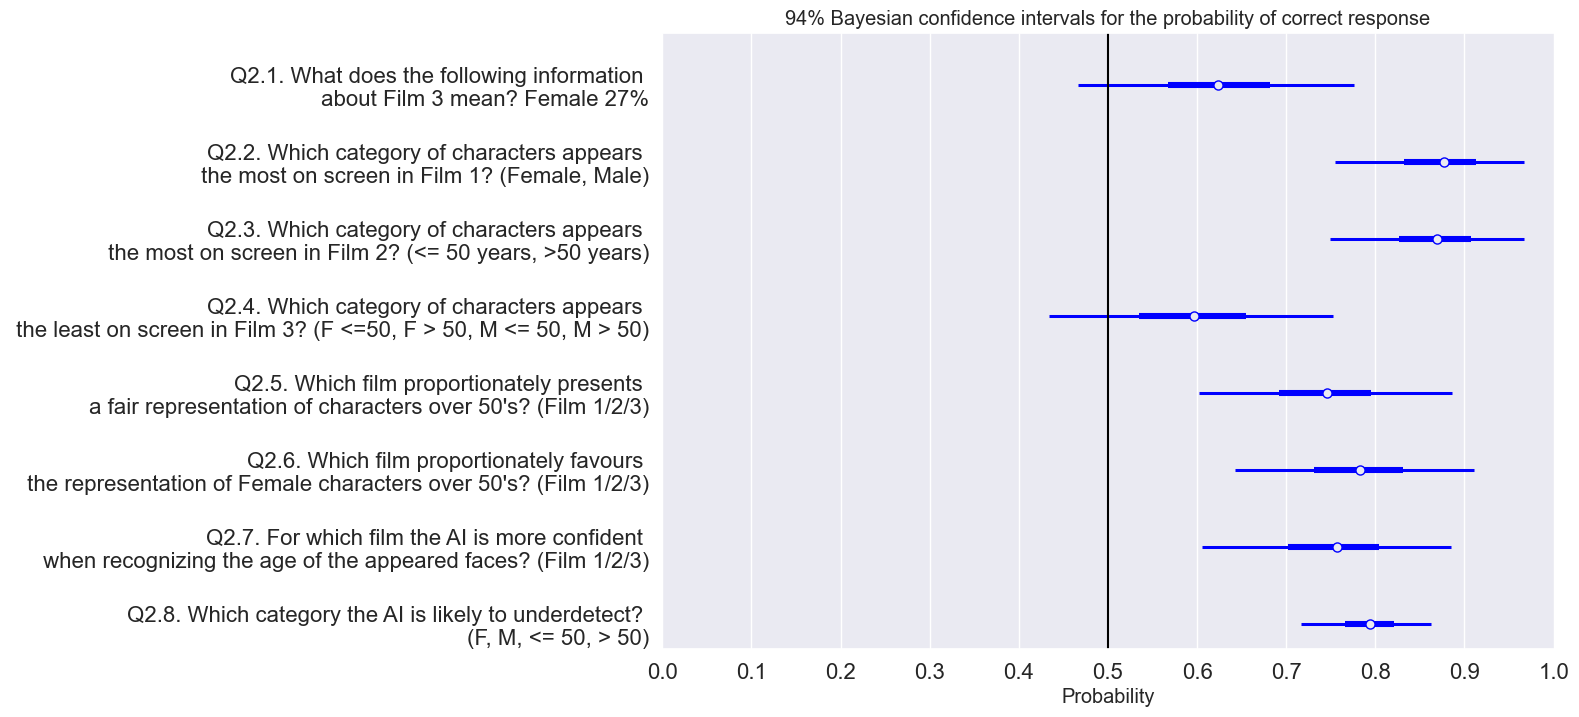

In [40]:
## 
ylabels = ["Q2.1. What does the following information \n about Film 3 mean? Female 27%",
                 "Q2.2. Which category of characters appears \n the most on screen in Film 1? (Female, Male)",
                 "Q2.3. Which category of characters appears \n the most on screen in Film 2? (<= 50 years, >50 years)",
                 "Q2.4. Which category of characters appears \n the least on screen in Film 3? (F <=50, F > 50, M <= 50, M > 50)",
                 "Q2.5. Which film proportionately presents \n a fair representation of characters over 50's? (Film 1/2/3)",
                 "Q2.6. Which film proportionately favours \n the representation of Female characters over 50's? (Film 1/2/3)",
                 "Q2.7. For which film the AI is more confident \n when recognizing the age of the appeared faces? (Film 1/2/3)",
                 "Q2.8. Which category the AI is likely to underdetect? \n(F, M, <= 50, > 50)"]
traces = [q21_trace,
                q22_trace,
                q23_trace,
                q24_trace,
                q25_trace,
                q26_trace,
                q27_trace,
                q28_trace]

## VISUALIZATION
ax = az.plot_forest(
    traces,
    model_names = ylabels,
    var_names=["theta"],
    combined = True,
    textsize = 16,
    colors=["blue"]*len(traces),
    figsize=(11.5,8),
)

## TITLE
ax[0].set_title("94% Bayesian confidence intervals for the probability of correct response", fontsize="large")

## AXES
ax[0].xaxis.set_label_text('Probability')
ax[0].xaxis.label.set_size('large')
ax[0].set_xlim([0, 1])
ax[0].set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
# ax[0].xaxis.get_ticklocs(minor=True)
# # Initialize minor ticks
# ax[0].minorticks_on()
# ax[0].xaxis.set_minor_locator(AutoMinorLocator())
# ax[0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0].set_ylim([-1, 23])
ax[0].set_yticks([l.get_data()[1][0] for l in ax[0].lines][::-1])
ax[0].set_yticklabels(ylabels)

## LEGEND
ax[0].get_legend().remove()

## BLACK HORIZONTAL LINES
ax[0].axvline(x=0.5, color='black')


##
plt.savefig('understandability.pdf',dpi=300, bbox_inches='tight')

## TRUST - USEFULNESS - USER EXPERIENCE

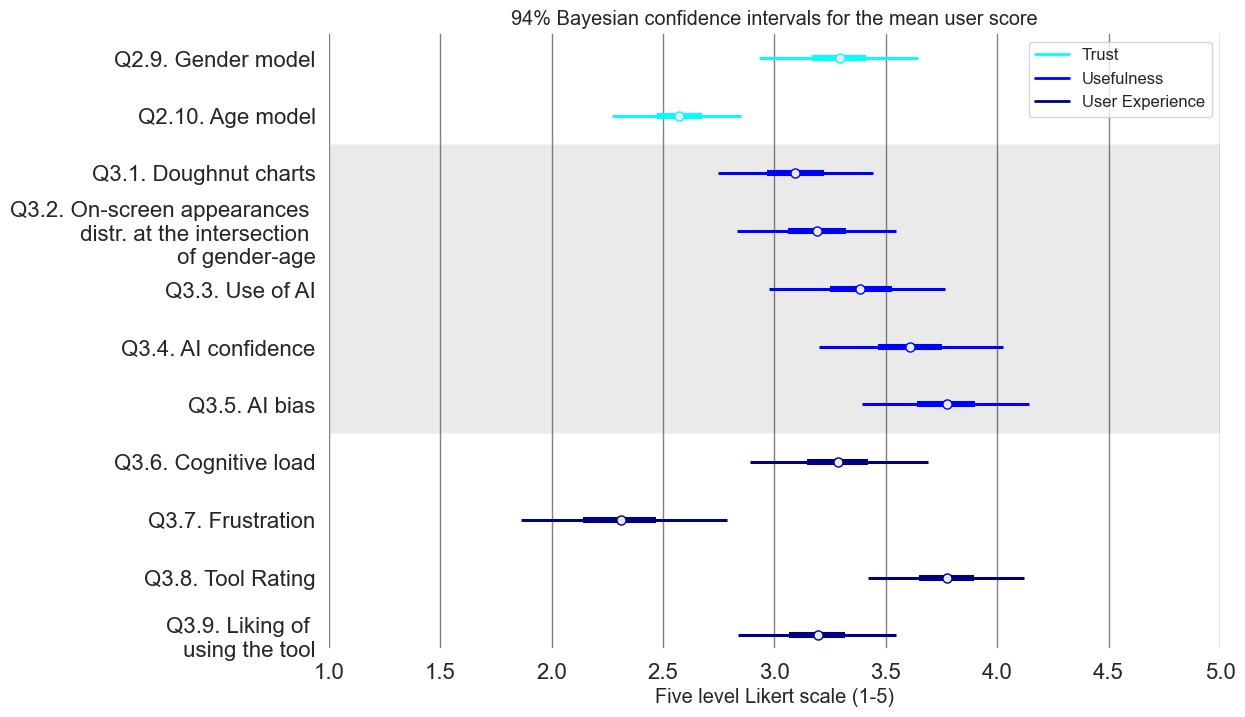

In [43]:
## TRUST
# ylabels_trust = ["How confident are you in the gender predictions the AI makes for the appeared faces in films?",
#                  "How confident are you in the age predictions the AI makes for the appeared faces in films?"]
ylabels_trust = ["Q2.9. Gender model",
                 "Q2.10. Age model"]
traces_trust = [trgen_trace,
                trage_trace]
## USEFULLNESS
# ylabels_usf = ["How useful are the pie charts in this context?",
#                  "How useful is it presenting the on-screen appearances distr. \n at the intersection of gender-age?",
#                  "How useful is the use of AI in this context?",
#                  "How useful is the information about the AI confidence levels in this context?",
#                 "How useful is the information about the AI bias levels in this context?"]
ylabels_usf = ["Q3.1. Doughnut charts",
                 "Q3.2. On-screen appearances \n distr. at the intersection \n of gender-age",
                 "Q3.3. Use of AI",
                 "Q3.4. AI confidence",
                "Q3.5. AI bias"]
traces_usf = [us1_trace,
             us2_trace,
             us3_trace,
             us4_trace,
             us5_trace] 

## USER EXPERIENCE
# ylabels_ue = ["How cognitively demanding it was to read and understand \n the AI-generated demographic analytics of the films based on this presentation?",
# "How much insecure, discouraged, irritated, stressed, and annoyed were you \n when looking at this presentation of the AI-generated demographic analytics of the films?",
# "Please rate the AI tool for analysing the character demographics",
#  "How much do you like using this tool?"]
ylabels_ue = ["Q3.6. Cognitive load",
                "Q3.7. Frustration",
                "Q3.8. Tool Rating",
                 "Q3.9. Liking of \n using the tool"]
traces_ue = [cl_trace, 
             fr_trace,
             rating_trace,
             lik_trace]

## VISUALIZATION
ax = az.plot_forest(
    traces_trust+traces_usf+traces_ue,
    model_names = ylabels_trust+ylabels_usf+ylabels_ue,
    var_names=["mean_rescaled_original"],
    combined = True,
    textsize = 16,
    colors=["cyan"]*len(traces_trust)+["blue"]*len(traces_usf)+["navy"]*len(traces_ue),
    figsize=(11.5,8),
)

## TITLE
ax[0].set_title("94% Bayesian confidence intervals for the mean user score", fontsize="large")

## AXES
ax[0].xaxis.set_label_text('Five level Likert scale (1-5)')
ax[0].xaxis.label.set_size('large')
ax[0].set_xlim([1, 5])
ax[0].set_ylim([-1, 43])
ax[0].set_yticks([l.get_data()[1][0] for l in ax[0].lines][::-1])
ax[0].set_yticklabels(ylabels_trust+ylabels_usf+ylabels_ue)

## LEGEND
# ax[0].get_legend().remove()
custom_lines = [Line2D([0], [0], color='cyan', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='navy', lw=2)]
ax[0].legend(custom_lines, ["Trust", "Usefulness", "User Experience"], 
             loc='upper right',
             facecolor = 'white',
               prop={'size': 12})
# ## BLACK HORIZONTAL LINES
ax[0].set_facecolor('white')
ax[0].axhspan(((16.5-12.375)/2)+12.375, ((37.125-33.0)/2)+33.0, facecolor='0.2', alpha=0.1)
ax[0].xaxis.grid(color='grey')

##
plt.savefig('likertscores.pdf',dpi=300, bbox_inches='tight')

In [41]:
# traces_trust = [trgen_trace,trage_trace]
# traces_usf = [us1_trace,
#              us2_trace,
#              us3_trace,
#              us4_trace,
#              us5_trace] 
# traces_ue = [cl_trace, 
#              fr_trace,
#              rating_trace,
#              lik_trace]
# traces = [q21_trace,
#                 q22_trace,
#                 q23_trace,
#                 q24_trace,
#                 q25_trace,
#                 q26_trace,
#                 q27_trace,
#                 q28_trace]
# az.plot_pair(
#     trgen_trace,
#     divergences=True,
#     textsize=22,
# )
## Rate of tool Q3.8
corr_rating = rating_trace.copy()
corr_rating.rename({"mean_rescaled_original": "mean_tool_rating"}, inplace=True)
corr_rating.posterior["mean_confidence_gender"] = trgen_trace.posterior['mean_score_gender']
corr_rating.posterior["mean_confidence_age"] = trage_trace.posterior['mean_score_age']
corr_rating.posterior["mean_usefulness_AI"] = us3_trace.posterior['mean_rescaled_original']
corr_rating.posterior["mean_usefulness_AIconfidence"] = us4_trace.posterior['mean_rescaled_original']
corr_rating.posterior["mean_usefulness_AIbias"] = us5_trace.posterior['mean_rescaled_original']
corr_rating.posterior["mean_usefulness_appearancesDistr."] = us2_trace.posterior['mean_rescaled_original']
corr_rating.posterior = corr_rating.posterior.drop_vars(['mean','std'])

## Liking of using tool Q3.9
corr_liking = lik_trace.copy()
corr_liking.rename({"mean_rescaled_original": "mean_liking_rating"}, inplace=True)
corr_liking.posterior["mean_confidence_gender"] = trgen_trace.posterior['mean_score_gender']
corr_liking.posterior["mean_confidence_age"] = trage_trace.posterior['mean_score_age']
corr_liking.posterior["mean_usefulness_AI"] = us3_trace.posterior['mean_rescaled_original']
corr_liking.posterior["mean_usefulness_AIconfidence"] = us4_trace.posterior['mean_rescaled_original']
corr_liking.posterior["mean_usefulness_AIbias"] = us5_trace.posterior['mean_rescaled_original']
corr_liking.posterior["mean_usefulness_appearancesDistr."] = us2_trace.posterior['mean_rescaled_original']
corr_liking.posterior = corr_liking.posterior.drop_vars(['mean','std'])

## Trust in gender model Q2.9
corr_trust_gender = trgen_trace.copy()
corr_trust_gender.posterior["mean_usefulness_AI"] = us3_trace.posterior['mean_rescaled_original']
corr_trust_gender.posterior["mean_usefulness_AIconfidence"] = us4_trace.posterior['mean_rescaled_original']
corr_trust_gender.posterior["mean_usefulness_AIbias"] = us5_trace.posterior['mean_rescaled_original']
corr_trust_gender.posterior["mean_usefulness_appearancesDistr."] = us2_trace.posterior['mean_rescaled_original']
corr_trust_gender.posterior = corr_trust_gender.posterior.drop_vars(['mean','std'])

## Trust in gender model Q2.10
corr_trust_age = trage_trace.copy()
corr_trust_age.posterior["mean_usefulness_AI"] = us3_trace.posterior['mean_rescaled_original']
corr_trust_age.posterior["mean_usefulness_AIconfidence"] = us4_trace.posterior['mean_rescaled_original']
corr_trust_age.posterior["mean_usefulness_AIbias"] = us5_trace.posterior['mean_rescaled_original']
corr_trust_age.posterior["mean_usefulness_appearancesDistr."] = us2_trace.posterior['mean_rescaled_original']
corr_trust_age.posterior = corr_trust_age.posterior.drop_vars(['mean','std'])

KeyError: "No variable named 'mean_score_gender'. Variables on the dataset include ['chain', 'draw', 'mean', 'std', 'mean_rescaled_original']"

In [95]:
# corr_rating.posterior.drop_vars(['mean','std'])
corr_rating

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: ylabel='mean_confidence_gender'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_confidence_age'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_usefulness_AI'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_usefulness_AIconfidence'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_usefulness_AIbias'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='mean_tool_rating', ylabel='mean_usefulness_appearancesDistr.'>,
        <Axes: xlabel='mean_confidence_gender'>,
        <Axes: xlabel='mean_confidence_age'>,
        <Axes: xlabel='mean_usefulness_AI'>,
        <Axes: xlabel='mean_usefulness_AIconfidence'>,
        <Axes: xlabel='mean_usefulness_AIbias'>]], dtype=object)

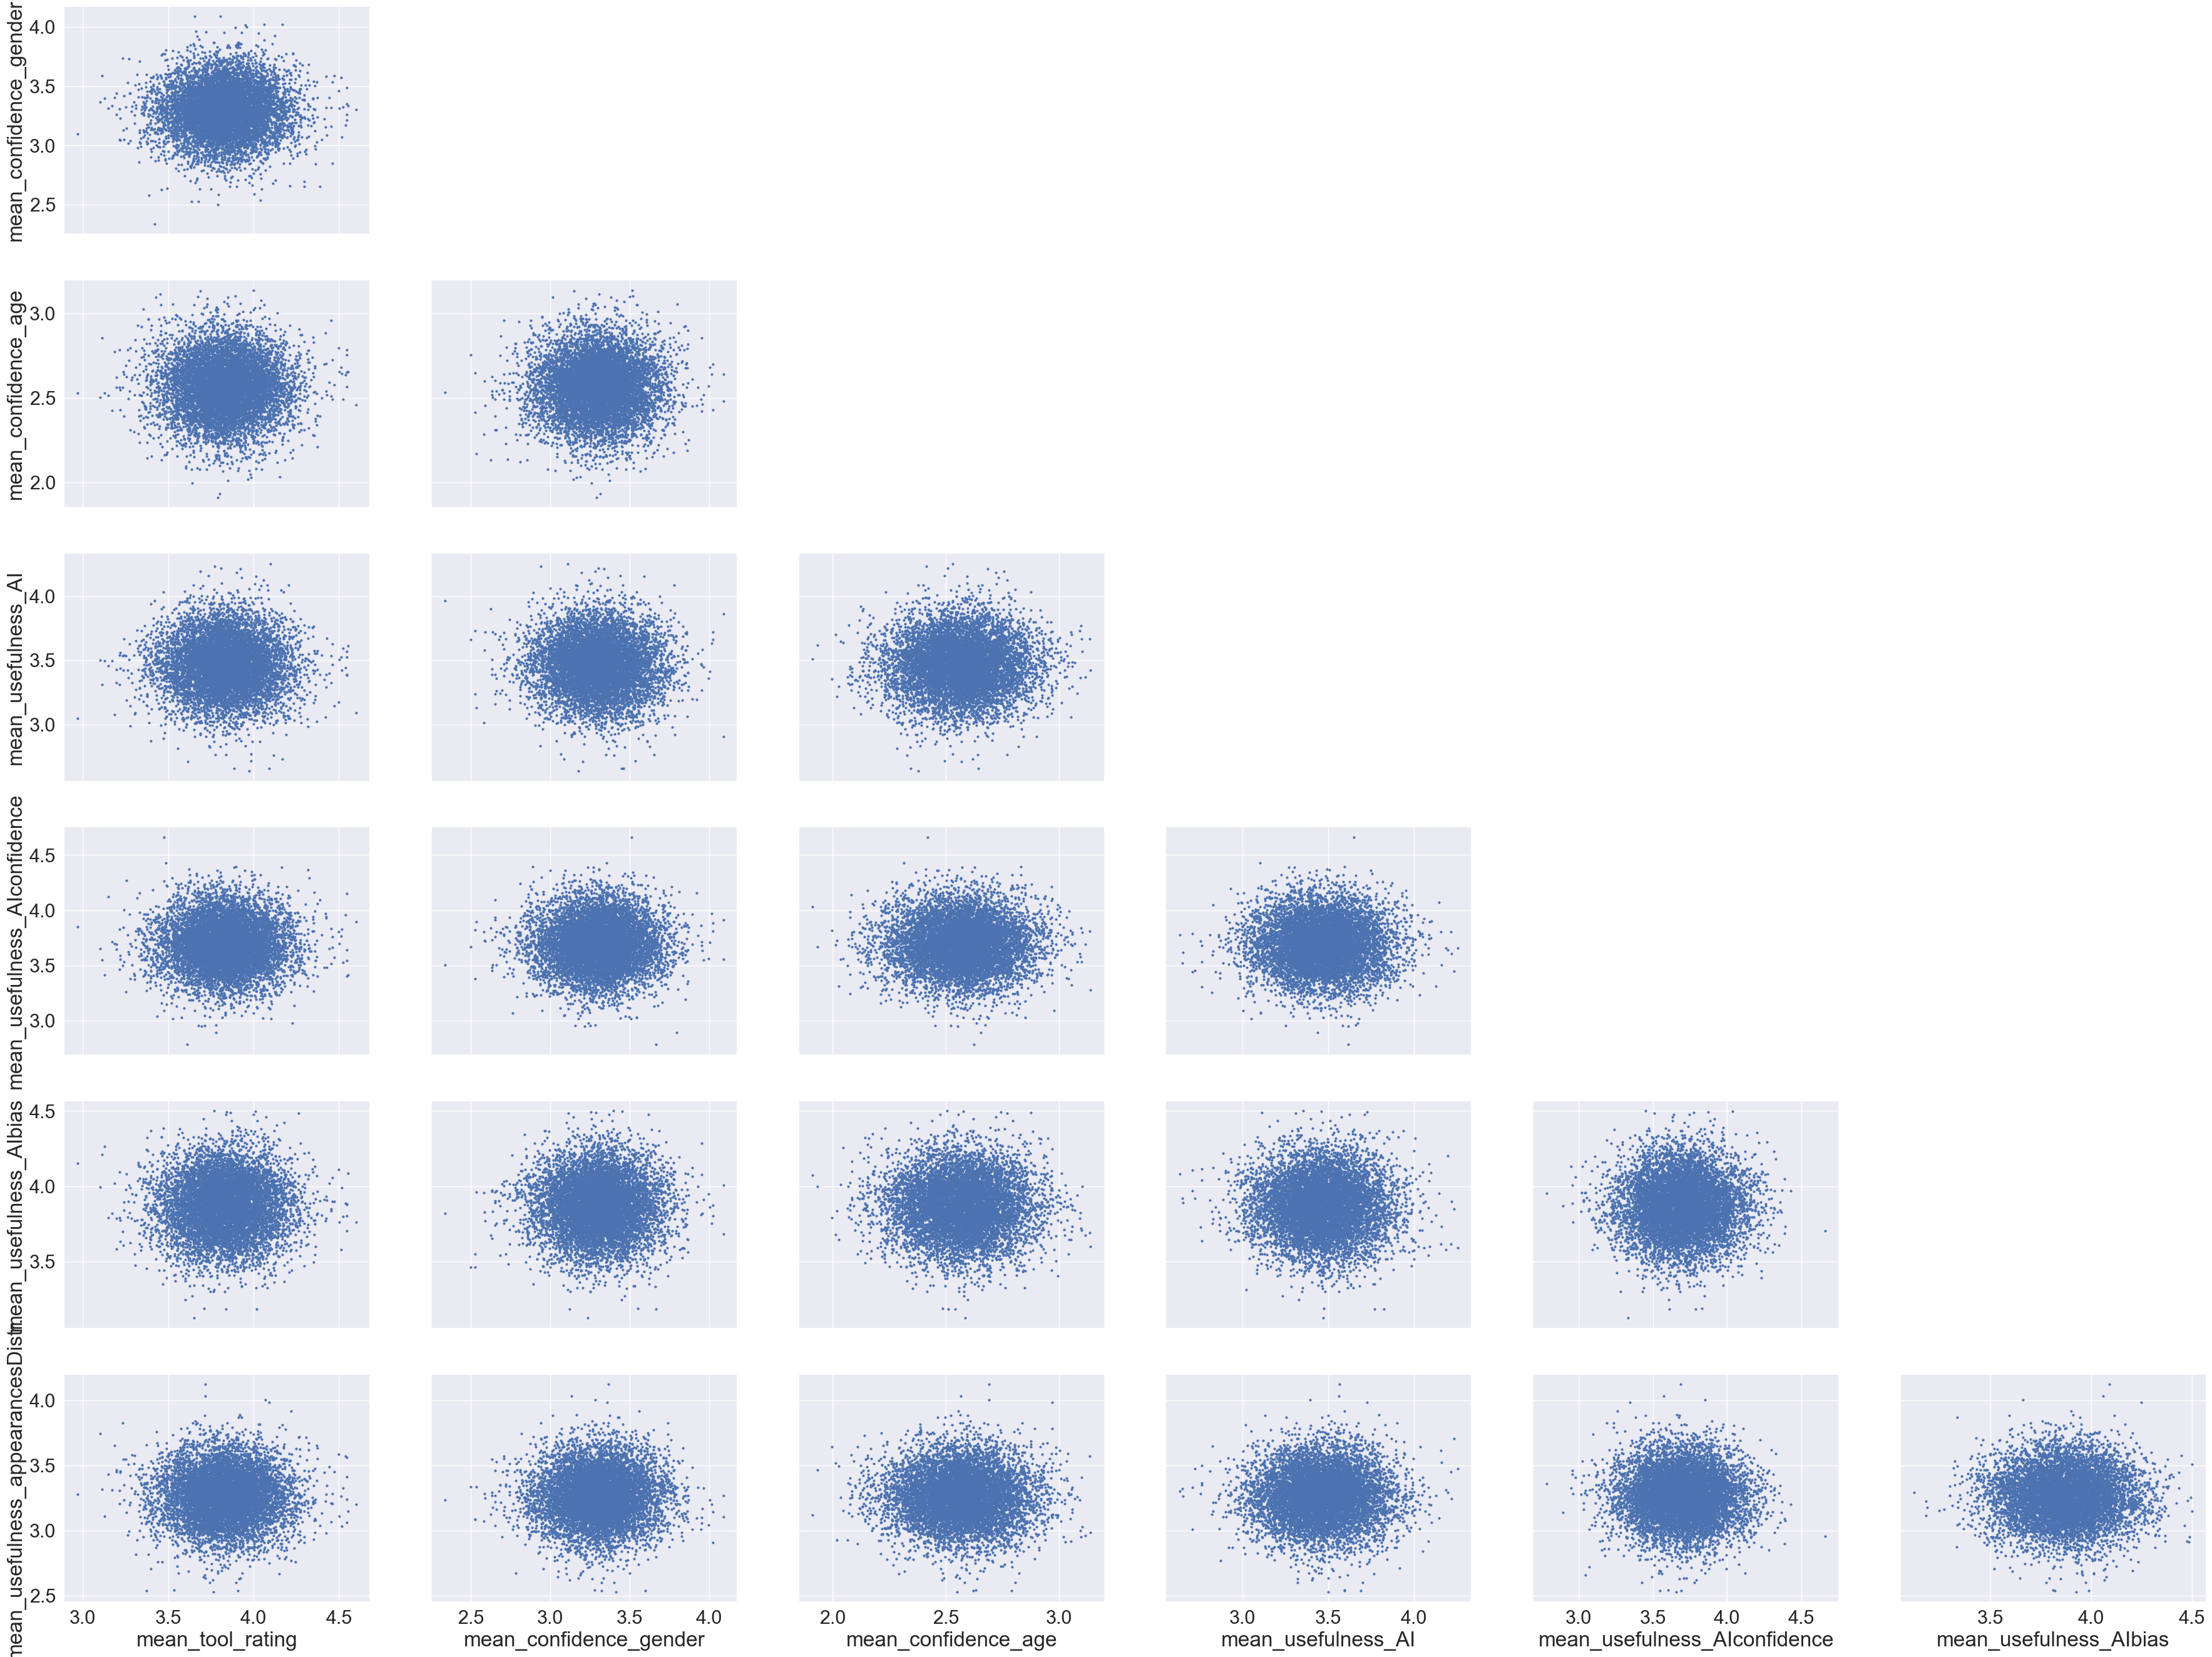

In [97]:
az.plot_pair(
    corr_rating,
    divergences=True,
    textsize=22,
)

array([[<Axes: ylabel='mean_confidence_gender'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_confidence_age'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_usefulness_AI'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_usefulness_AIconfidence'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_usefulness_AIbias'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='mean_liking_rating', ylabel='mean_usefulness_appearancesDistr.'>,
        <Axes: xlabel='mean_confidence_gender'>,
        <Axes: xlabel='mean_confidence_age'>,
        <Axes: xlabel='mean_usefulness_AI'>,
        <Axes: xlabel='mean_usefulness_AIconfidence'>,
        <Axes: xlabel='mean_usefulness_AIbias'>]], dtype=object)

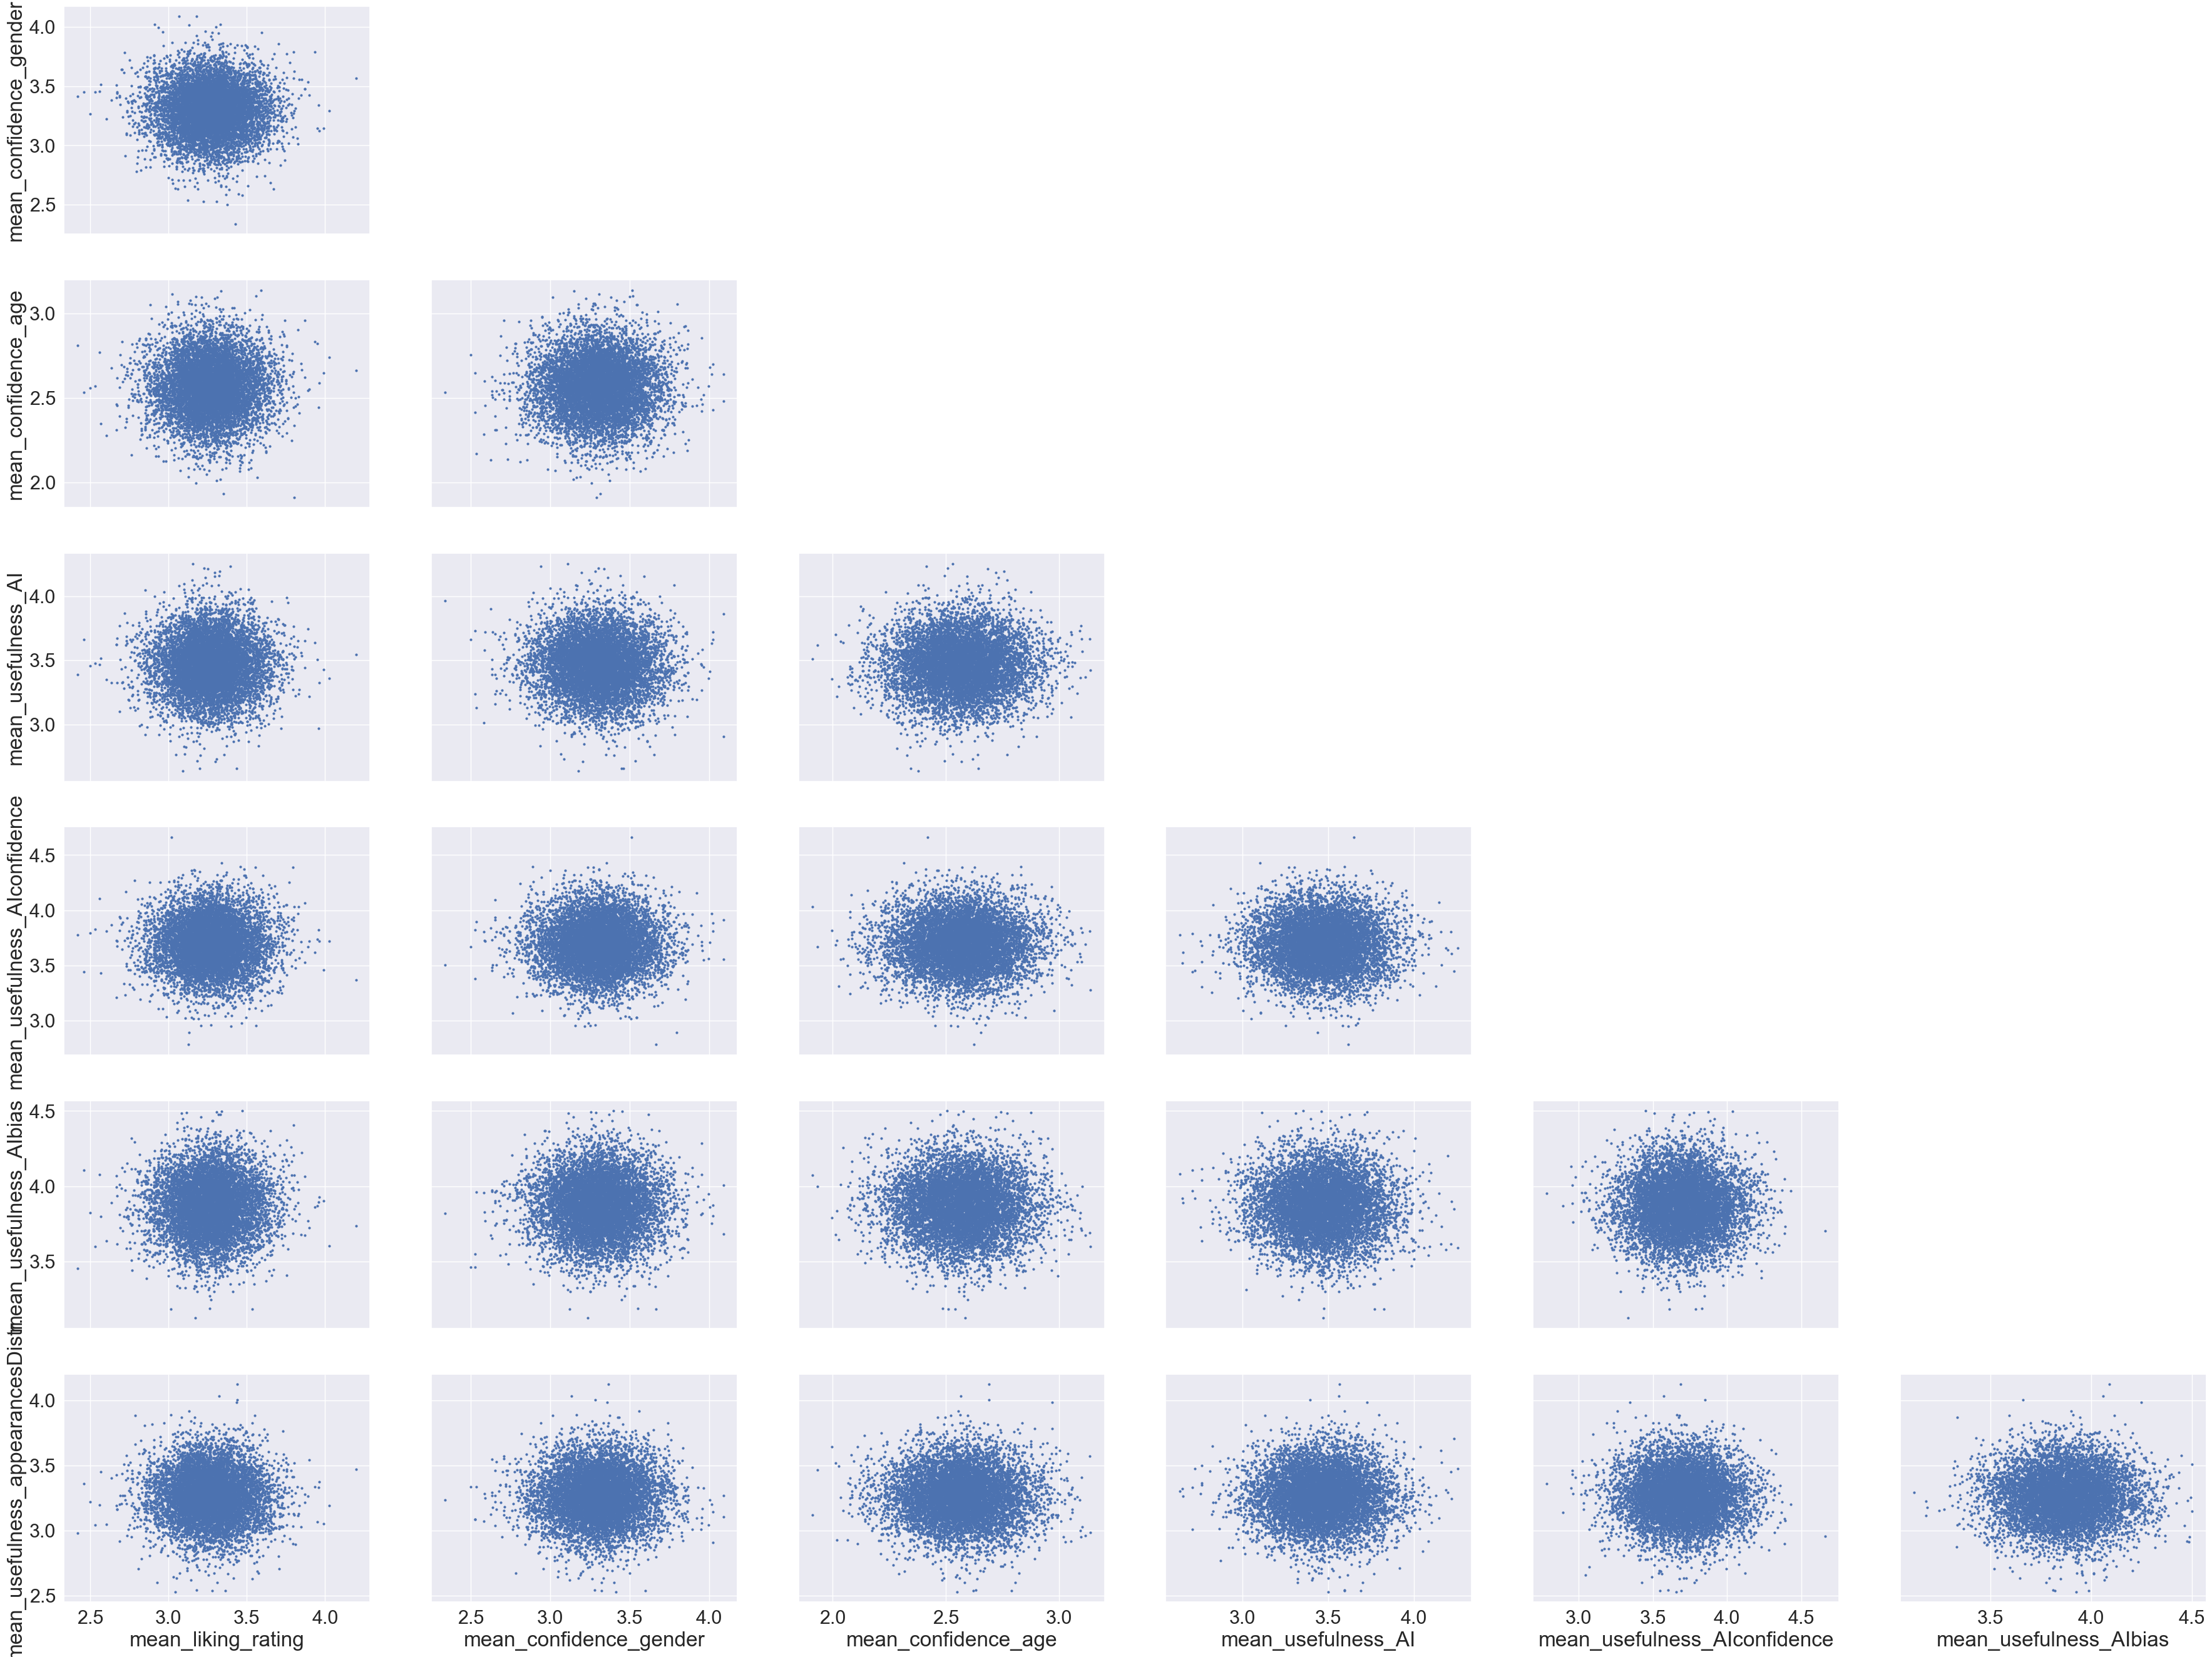

In [98]:
az.plot_pair(
    corr_liking,
    divergences=True,
    textsize=22,
)

array([[<Axes: ylabel='mean_usefulness_AI'>, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='mean_usefulness_AIconfidence'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='mean_usefulness_AIbias'>, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='mean_score_gender', ylabel='mean_usefulness_appearancesDistr.'>,
        <Axes: xlabel='mean_usefulness_AI'>,
        <Axes: xlabel='mean_usefulness_AIconfidence'>,
        <Axes: xlabel='mean_usefulness_AIbias'>]], dtype=object)

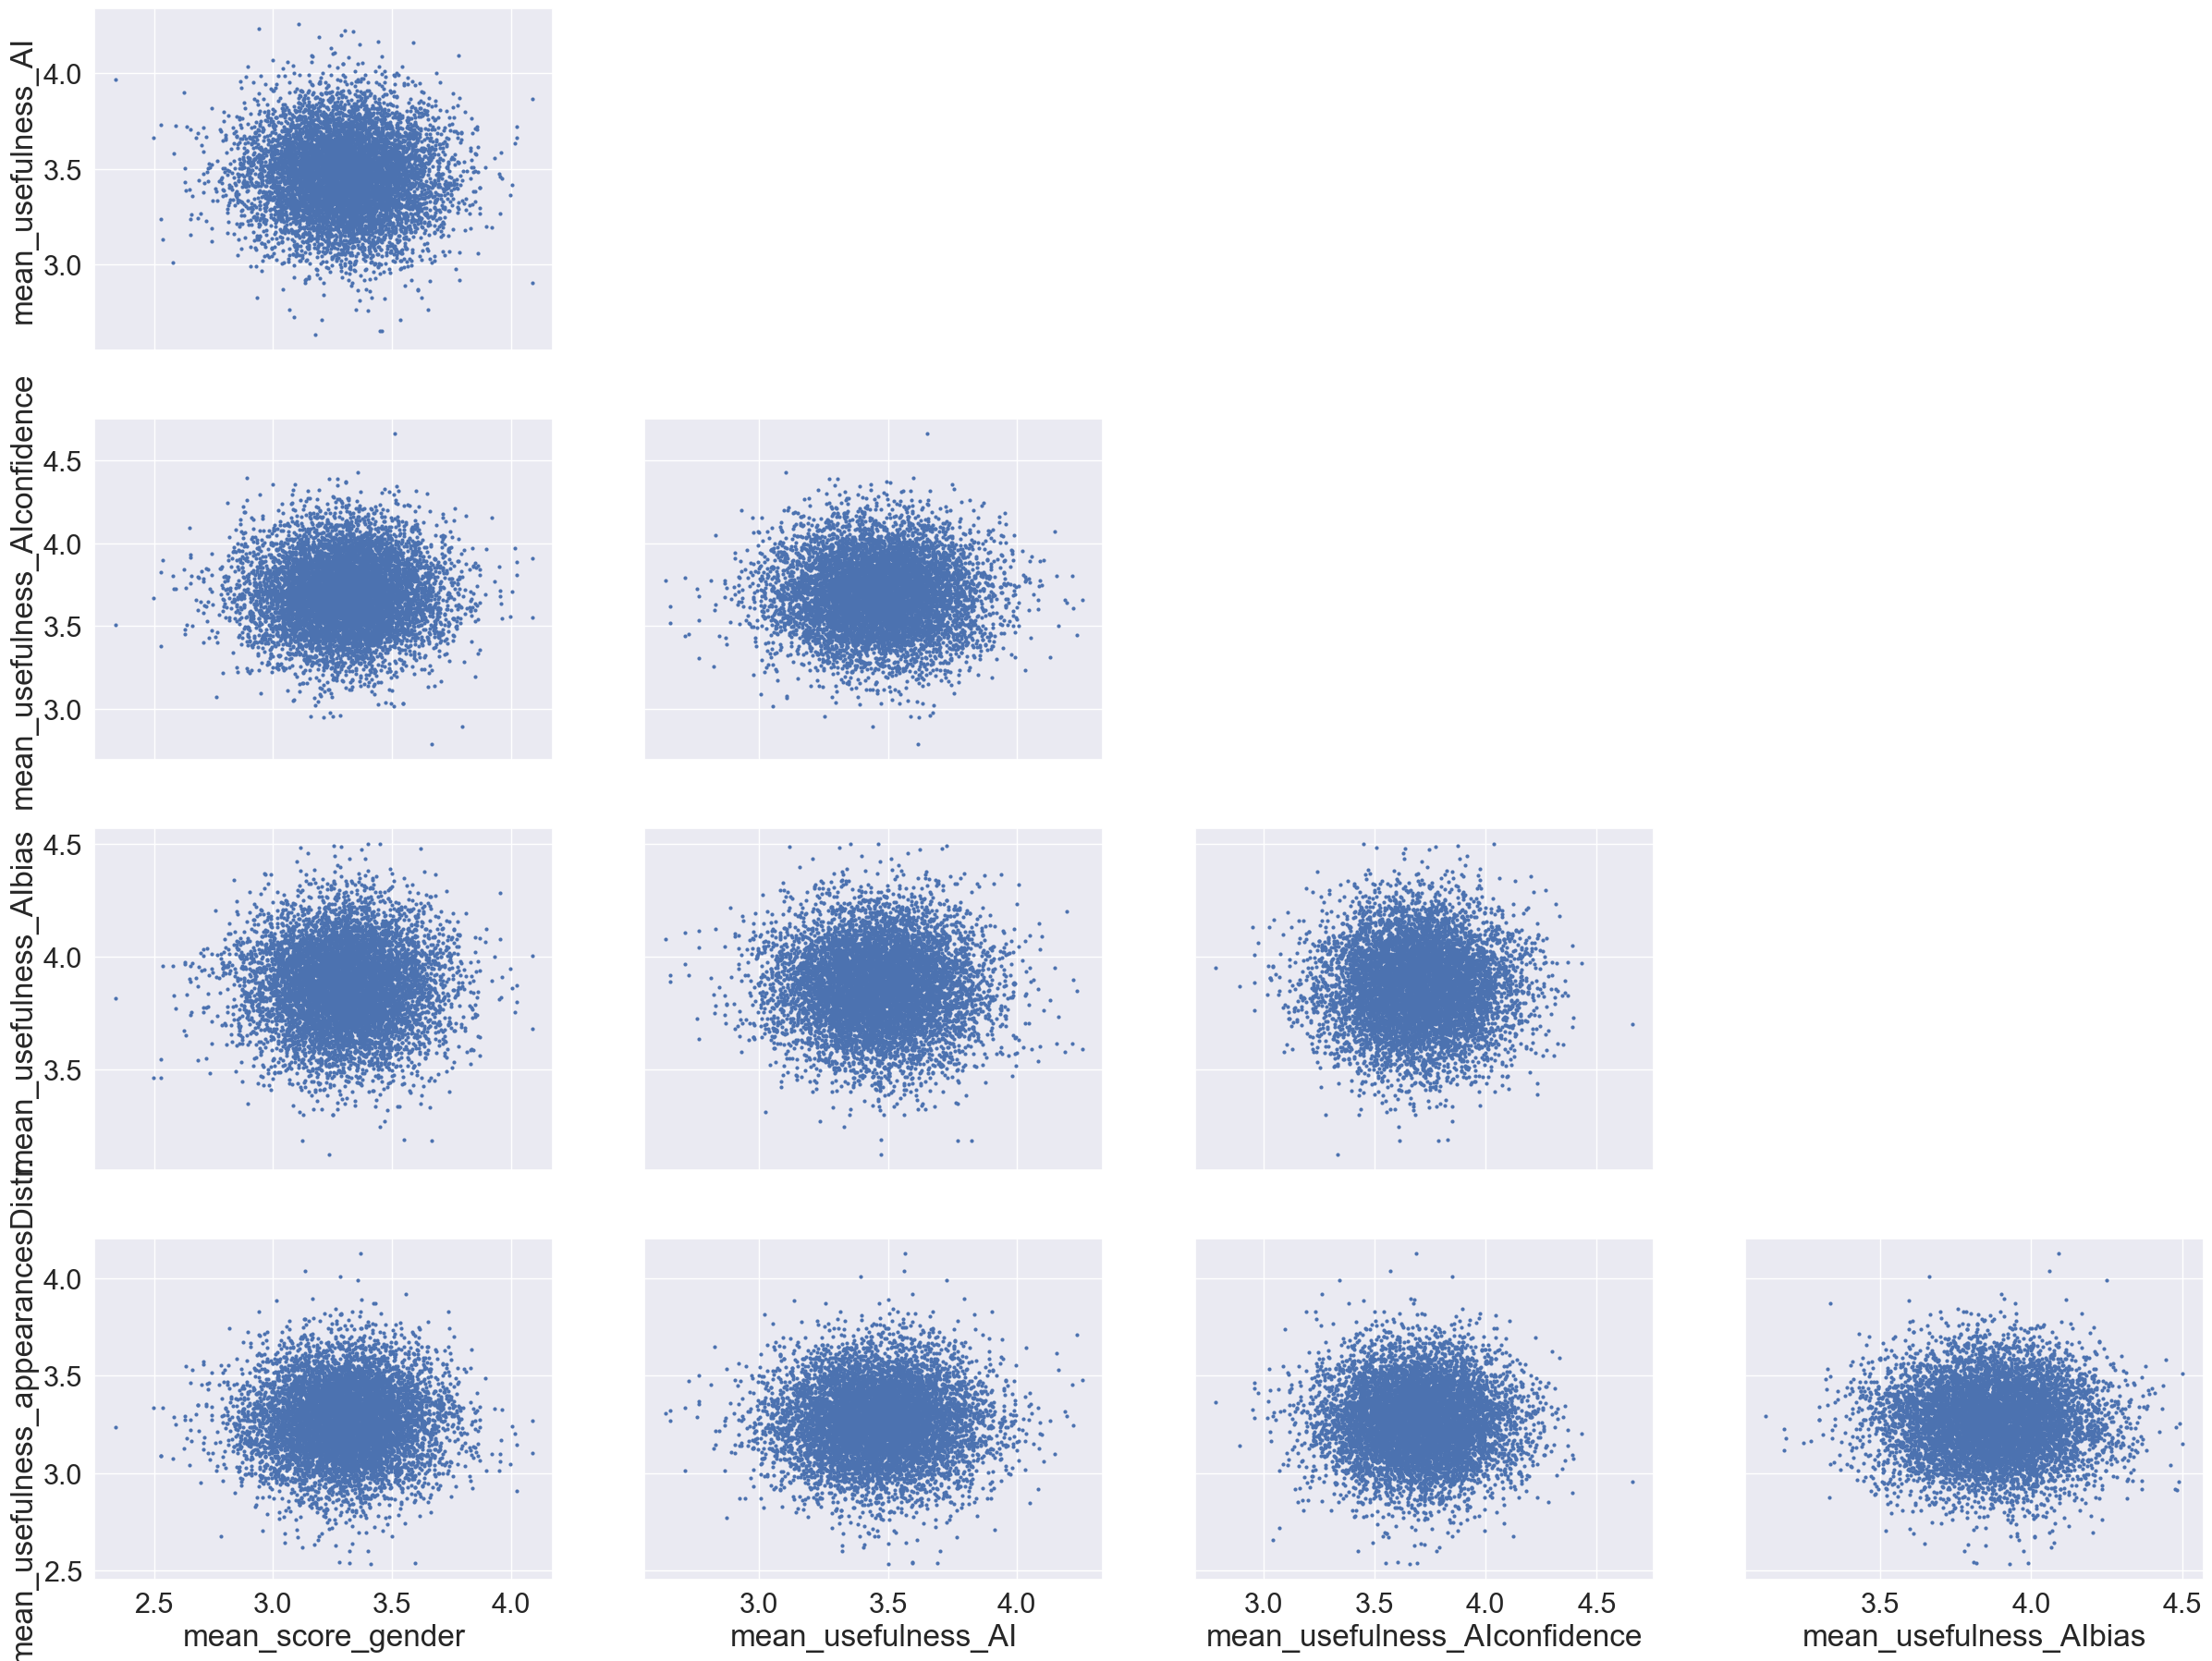

In [99]:
az.plot_pair(
    corr_trust_gender,
    divergences=True,
    textsize=22,
)

## CORRELATIONs

In [101]:
age = df[[list(df.columns)[20]]]
gender = df[[list(df.columns)[21]]]
education = df[[list(df.columns)[23]]]
ai_programming_experience = df[[list(df.columns)[25]]]
freq_watching = df[[list(df.columns)[27]]]
platforms = df[[list(df.columns)[28]]]

In [102]:
age

,What is your age?
0,26-40
1,18-25
2,18-25
3,18-25
4,18-25
5,41-50
6,18-25
7,18-25
8,26-40
9,18-25
